In [51]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import gc
from tqdm import tqdm
import time
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoModel, AutoTokenizer
from transformers import BatchEncoding
import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import pdb

import wandb

# Defining global parameters

In [2]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": get_available_device(),
    'labels': ['unable_to_assess', 'not_close_match','close_match', 'near_exact_match', 'exact_match'], # 'unable_to_assess', 'not_close_match','close_match', 'near_exact_match', 'exact_match'
    'FP': 'molformer', # 'fp', 'molformer', 'ECFP', 'grover'
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=CONFIG['seed'])

# Read the data that has duplicates REMOVED
## Validation set of 20% of the size

In [3]:
train_df = pd.read_pickle('../data/train_split_remove_duplicates_all_embeddings.pkl')
valid_df = pd.read_pickle('../data/valid_split_remove_duplicates_all_embeddings.pkl')

In [4]:
if CONFIG['FP'] == 'ECFP':
    CONFIG['input_size'] = 2048
elif CONFIG['FP'] == 'molformer':
    CONFIG['input_size'] = 768
elif CONFIG['FP'] == 'fp':
    CONFIG['input_size'] = 2215
elif CONFIG['FP'] == 'grover':
    CONFIG['input_size'] = 5000


## Wrapping in Pytorch Dataset

In [5]:
class EnvedaDatasetSmileMolformer(Dataset):
    def __init__(self, dataframe, labels = ['unable_to_assess', 'close_match', 'not_close_match', 
                                            'near_exact_match', 'exact_match']):
        """
        Args:
            dataframe (pd.DataFrame): A DataFrame containing 'ground_truth_embeddings', 
                                       'predicted_embeddings', and output columns.
        """
        self.dataframe = dataframe
        
        # Convert embeddings to tensors
        self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)
        self.predicted_embeddings = torch.tensor(dataframe['predicted_embeddings'].tolist(), dtype=torch.float32)
        
        # Get molecular smiles
        self.ground_truth_smiles = dataframe['ground_truth_smiles'].to_list()
        self.predicted_smiles = dataframe['predicted_smiles'].to_list()

        # Convert labels to tensor
        self.labels = torch.tensor(dataframe[labels].values, dtype=torch.float32)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        #return self.ground_truth_embeddings[idx].squeeze(0), self.predicted_embeddings[idx].squeeze(0), self.labels[idx]
        return self.ground_truth_smiles[idx], self.predicted_smiles[idx], self.labels[idx]

In [6]:
trainset = EnvedaDatasetSmileMolformer(dataframe=train_df, labels=CONFIG['labels'])
validset = EnvedaDatasetSmileMolformer(dataframe=valid_df, labels=CONFIG['labels'])

C:\Users\86136\AppData\Local\Temp\ipykernel_86784\3388207282.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)


## Wrapping in Pytorch DataLoader

In [7]:
trainloader, validloader = DataLoader(trainset, batch_size=CONFIG['train_batch_size']), \
                           DataLoader(validset, batch_size=CONFIG['valid_batch_size'])

In [8]:
gt, pred, labels = next(iter(trainloader))
print(len(gt), len(pred), labels.shape)


16 16 torch.Size([16, 5])


# Defining neural network

In [11]:
print(torch.cuda.is_available())

False


In [10]:
molformer_embedder = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True).to(CONFIG['device'])
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [12]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, feature_embedder=molformer_embedder, input_dim=768, output_dim=4):
        super(SiameseNetwork, self).__init__()
        self.smiler_embedder = feature_embedder
        self.smiler_embedder.eval() 
        # Freeze feature embedder
        # for param in self.smiler_embedder.parameters():
        #     param.requires_grad = False
        
        self.fc = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2))

        self.fc5 = nn.Linear(128, output_dim)

        
    def forward_one(self, x):
        return self.fc(x)

    def forward(self, input1, input2):
        # Check if input1 is a dictionary or tensor
        if isinstance(input1, BatchEncoding) or isinstance(input1, dict):
            # pdb.set_trace()
            input1 = self.smiler_embedder(**input1, output_hidden_states=True).pooler_output
        elif isinstance(input1, torch.Tensor):
            # pdb.set_trace()
            input1 = self.smiler_embedder(input1, output_hidden_states=True).pooler_output  # Adjust as needed for tensor input

        # Check if input2 is a dictionary or tensor
        if isinstance(input2, BatchEncoding) or isinstance(input2, dict):
            input2 = self.smiler_embedder(**input2, output_hidden_states=True).pooler_output
        elif isinstance(input2, torch.Tensor):
            input2 = self.smiler_embedder(input2, output_hidden_states=True).pooler_output  # Adjust as needed for tensor input
        # pdb.set_trace()
        out1 = self.forward_one(input1)
        out2 = self.forward_one(input2)
        # pdb.set_trace()
        # Combine both outputs by subtraction
        combined = torch.sub(out1, out2)  # maybe torch.abs(out1 - out2)
        output = self.fc5(combined)                  # Outputs raw logits
        return output



In [13]:
# model = SiameseNetwork(output_dim=5, feature_embedder=molformer_embedder)
# model.to(CONFIG['device'])
    
# model((tokenizer(gt, return_tensors='pt', padding=True, truncation=True)).to(CONFIG['device']), 
#       (tokenizer(pred, return_tensors='pt', padding=True, truncation=True)).to(CONFIG['device']))
# # model(gt, pred)

# Validation 

In [14]:

@torch.no_grad()
def valid_one_epoch(model, dataloader, criterion, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_f1 = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds = tokenizer(gt, return_tensors='pt', padding=True, truncation=True), \
                    tokenizer(preds, return_tensors='pt', padding=True, truncation=True)
        # pdb.set_trace()
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = targets.shape[0]
        
        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
        
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).astype(float)
        
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                        Valid_F1=epoch_f1,
                        )   
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

## Loading pretrained model

In [15]:
model = SiameseNetwork(input_dim=CONFIG['input_size'], output_dim=len(CONFIG['labels'])).to(CONFIG['device'])
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])

class_distribution = {'unable_to_assess': 10,
                      'not_close_match': 109, 
                      'close_match': 125, 
                      'near_exact_match': 66, 
                      'exact_match': 12,
                      'good_enough_for_prioritization': 224}

# Calculate class weights
total_samples = sum(class_distribution.values())
class_weights = {label: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()}

# Convert weights to a tensor
weights = torch.tensor([class_weights['unable_to_assess'],
                        class_weights['not_close_match'],
                        class_weights['close_match'],
                        class_weights['near_exact_match'],
                        class_weights['exact_match']], dtype=torch.float32).to(CONFIG['device'])

# find the indeces of keys in class_distribution in CONFIG['labels']
weights = torch.tensor([class_weights[c] for c in CONFIG['labels']], dtype=torch.float32).to(CONFIG['device'])

# Modify the loss function in your training loop
criterion = nn.CrossEntropyLoss(weight=weights)



# Load pretrained model

In [16]:
# set Strict to false because of the newly added MolFormer embedder
model.load_state_dict(torch.load('../results/best_F1_model_siamese_multiclass_sub_molformer.bin', map_location=CONFIG['device']), strict=False) 

_IncompatibleKeys(missing_keys=['smiler_embedder.embeddings.word_embeddings.weight', 'smiler_embedder.encoder.layer.0.attention.self.query.weight', 'smiler_embedder.encoder.layer.0.attention.self.query.bias', 'smiler_embedder.encoder.layer.0.attention.self.key.weight', 'smiler_embedder.encoder.layer.0.attention.self.key.bias', 'smiler_embedder.encoder.layer.0.attention.self.value.weight', 'smiler_embedder.encoder.layer.0.attention.self.value.bias', 'smiler_embedder.encoder.layer.0.attention.self.feature_map.weight', 'smiler_embedder.encoder.layer.0.attention.output.dense.weight', 'smiler_embedder.encoder.layer.0.attention.output.dense.bias', 'smiler_embedder.encoder.layer.0.attention.output.LayerNorm.weight', 'smiler_embedder.encoder.layer.0.attention.output.LayerNorm.bias', 'smiler_embedder.encoder.layer.0.intermediate.dense.weight', 'smiler_embedder.encoder.layer.0.intermediate.dense.bias', 'smiler_embedder.encoder.layer.0.output.dense.weight', 'smiler_embedder.encoder.layer.0.output

In [17]:
val_epoch_loss_molformer, val_epoch_auroc_molformer, val_epoch_f1_molformer = valid_one_epoch(
    model=model,
    dataloader=validloader,
    criterion=criterion,
    epoch=1
)

  0%|          | 0/2 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\86136\AppData\Roaming\Python\Python39\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
 50%|█████     | 1/2 [00:22<00:22, 22.83s/it, Epoch=1, Valid_Auroc=0.512, Valid_F1=0.428, Valid_Loss=1.86]C:\Users\86136\AppData\Roaming\Python\Python39\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
d:\cs\envs\dpl\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.

# Interpretability with Integrated Gradients

In [18]:

# def prepare_input(smile1, smile2):
#     # Tokenize SMILES strings
#     input1 = tokenizer(smile1, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
#     input2 = tokenizer(smile2, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    
#     # Combine into a dictionary
#     return {
#         "input_ids": input1["input_ids"],
#         "attention_mask": input1["attention_mask"],
#         "input_ids_2": input2["input_ids"],
#         "attention_mask_2": input2["attention_mask"]
#     }



# # Function to interpret the model's prediction
# def interpret_model(smile1, smile2):
#     # Prepare inputs
#     input_dict = prepare_input(smile1, smile2)

#     gt_smile = {'input_ids': input_dict["input_ids"].long(), \
#                          'attention_mask': input_dict["attention_mask"].float()}
#     pred_smile = {'input_ids': input_dict["input_ids_2"].long(), \
#                       'attention_mask': input_dict["attention_mask_2"].float()}
#     # Set model to evaluation mode
#     model.eval()

#     # Create IntegratedGradients object
#     ig = IntegratedGradients(model)

#     # Forward pass to get output
#     output = model(gt_smile, pred_smile)
#     output = torch.softmax(output, dim=1)
    
#     # Get the index of the predicted class (assuming binary classification)
#     predicted_class = torch.tensor([0, 1, 0, 0, 0])

#     # Calculate attributions for both inputs
#     attributions1 = ig.attribute((gt_smile['input_ids'], pred_smile['input_ids']), target=predicted_class)
#     pdb.set_trace()
#     attributions2 = ig.attribute(pred_smile['input_ids'], target=predicted_class)

#     return attributions1, attributions2

# # Example usage
# idx = 42
# smile1 = valid_df['predicted_smiles'].iloc[idx]  # Example SMILE string 1
# smile2 = valid_df['ground_truth_smiles'].iloc[idx]  # Example SMILE string 2

# attributions1, attributions2 = interpret_model(smile1, smile2)

# # Convert attributions to numpy for easier visualization if needed
# attributions1_np = attributions1.detach().numpy()
# attributions2_np = attributions2.detach().numpy()

# print("Attributions for SMILE 1:", attributions1_np)
# print("Attributions for SMILE 2:", attributions2_np)


In [117]:
def prepare_input(smile1, smile2):
    # Tokenize SMILES strings
    input1 = tokenizer(smile1, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    input2 = tokenizer(smile2, return_tensors='pt', padding=True, truncation=True).to(CONFIG['device'])
    
    # Combine into a dictionary
    return {
        "input_ids": input1["input_ids"],
        "attention_mask": input1["attention_mask"],
        "input_ids_2": input2["input_ids"],
        "attention_mask_2": input2["attention_mask"]
    }

def integrated_gradients(model, smile1, smile2, baseline=None, steps=20):
    if baseline is None:
        # pdb.set_trace()
        baseline = { 
                    "input_ids": torch.zeros(len(tokenizer(smile1)["input_ids"])).to(CONFIG['device']),
                    "attention_mask": torch.ones(len(tokenizer(smile1)["attention_mask"])).to(CONFIG['device']),
                    "input_ids_2": torch.zeros(len(tokenizer(smile2)["input_ids"])).to(CONFIG['device']),
                    "attention_mask_2": torch.ones(len(tokenizer(smile2)["attention_mask"])).to(CONFIG['device']) 
                }

    # Prepare inputs as dictionaries
    input_dict = prepare_input(smile1, smile2)

    # Scale inputs between baseline and input; only input IDs are scaled
    scaled_inputs = [{k: baseline[k] + (float(i) / steps) * (input_dict[k] - baseline[k]) for k in baseline.keys()} for i in range(steps + 1)]
    # pdb.set_trace()
    # Collect gradients
    grads_gt = []
    grads_pred = []
    for scaled_input in scaled_inputs:
        # scaled_input_tensor = {k: v.requires_grad_() for k, v in scaled_input.items()}
        
        gt_smile = {'input_ids': scaled_input["input_ids"].long(), \
                         'attention_mask': scaled_input["attention_mask"].float().requires_grad_(True)}
        pred_smile = {'input_ids': scaled_input["input_ids_2"].long(), \
                      'attention_mask': scaled_input["attention_mask_2"].float().requires_grad_(True)}
        
        output = model(gt_smile, pred_smile)
        model.zero_grad()
        
        target_one_hot = torch.eye(output.shape[1])[torch.argmax(output)]
        # Use the one-hot encoded target for backpropagation
        # pdb.set_trace()
        output.backward(torch.tensor(target_one_hot.clone().detach().requires_grad_(True)).to(CONFIG['device']).float().unsqueeze(0))
        # pdb.set_trace()
        grads_gt.append(gt_smile['attention_mask'].grad.detach().cpu().numpy())     # should be input ids, but they don't have gradients
        grads_pred.append(pred_smile['attention_mask'].grad.detach().cpu().numpy())
    # Average the gradients
    # pdb.set_trace()
    avg_grads_gt = np.mean(grads_gt[:-1], axis=0)
    avg_grads_pred = np.mean(grads_pred[:-1], axis=0)

    # Compute integrated gradients
    integrated_grads_gt = (input_dict['attention_mask']).detach().cpu().numpy() * avg_grads_gt
    integrated_grads_pred = (input_dict['attention_mask_2']).detach().cpu().numpy() * avg_grads_pred
    print(target_one_hot)
    return integrated_grads_gt, integrated_grads_pred


def highlight_smiles(smiles, integrated_grads):
    # Normalize integrated gradients for visualization
    norm_grads = (integrated_grads[0] - np.min(integrated_grads[0])) / (np.max(integrated_grads[0]) - np.min(integrated_grads[0]))
    
    plt.figure(figsize=(10, 5))
    
    # Create a color map based on normalized gradients
    colors = plt.cm.viridis(norm_grads)
    
    # Plot each token with its corresponding gradient color
    for i, (token, color) in enumerate(zip(smiles, colors)):
        # pdb.set_trace()
        plt.text(i, 0, token, fontsize=12, ha='center', va='center', color=color)
    
    plt.title('Highlighting Important SMILE Tokens')
    plt.axis('off')
    plt.show()


In [107]:
# Example one-hot encoding for target class (e.g., exact_match)
idx = 1
smile1 = valid_df['predicted_smiles'].iloc[idx]  # Example SMILE string 1
smile2 = valid_df['ground_truth_smiles'].iloc[idx]  # Example SMILE string 2

# target_one_hot = [0, 0, 0, 0, 1]  # Assuming exact_match is the fifth class

# Compute integrated gradients
integrated_grads_gt, integrated_grads_pred = integrated_gradients(model, smile1, smile2)

# Highlight structures based on SMILE tokens
# highlight_smiles(smiles=[smile1, smile2], integrated_grads=integrated_grads_gt)


C:\Users\86136\AppData\Local\Temp\ipykernel_86784\3922143985.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output.backward(torch.tensor(target_one_hot.clone().detach().requires_grad_(True)).to(CONFIG['device']).float().unsqueeze(0))


tensor([0., 1., 0., 0., 0.])


In [123]:
def visualize_molecule(smile1, smile2, grads1, grads2):
    """
    Visualizes two molecules from SMILES strings with integrated gradient scores.
    
    Parameters:
        smile1 (str): The first SMILES string.
        smile2 (str): The second SMILES string.
        tokens1 (torch.Tensor): Tokenized form of the first SMILES string.
        tokens2 (torch.Tensor): Tokenized form of the second SMILES string.
        grads1 (np.ndarray): Integrated gradients for the first molecule.
        grads2 (np.ndarray): Integrated gradients for the second molecule.
    """
    
    # Convert SMILES to RDKit molecules
    mol1 = Chem.MolFromSmiles(smile1)
    mol2 = Chem.MolFromSmiles(smile2)

    # Get atom indices from tokenized SMILES
    atom_indices1 = [i for i in range(mol1.GetNumAtoms())]
    atom_indices2 = [i for i in range(mol2.GetNumAtoms())]

    # Normalize integrated gradient scores for better visualization
    normed_scores1 = grads1[0] # - np.min(grads1[0])) / (np.max(grads1[0]) - np.min(grads1[0]))
    normed_scores2 = grads2[0] # - np.min(grads2[0])) / (np.max(grads2[0]) - np.min(grads2[0]))
    # pdb.set_trace()
    # Create color maps based on integrated gradient scores
    colors1 = plt.cm.viridis(normed_scores1)
    colors2 = plt.cm.viridis(normed_scores2)
    pdb.set_trace()
    # Create a figure for visualizations
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Molecule 1 without colors
    img1_no_color = Draw.MolToImage(mol1,
                                     size=(300, 300),
                                     kekulize=True)
    
    axs[0, 0].imshow(img1_no_color)
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Ground Truth Molecule')
    
    # Molecule 1 with colors based on integrated gradients
    img1_colored = Draw.MolToImage(mol1,
                                    size=(300, 300),
                                    kekulize=True,
                                    highlightAtoms=atom_indices1,
                                    highlightAtomColors={i: colors1[i] for i in atom_indices1})
    
    axs[0, 1].imshow(img1_colored)
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Ground Truth Molecule with Integrated Gradient Attention Scores')


    # Molecule 2 without colors
    img2_no_color = Draw.MolToImage(mol2,
                                     size=(300, 300),
                                     kekulize=True)
    
    axs[1, 0].imshow(img2_no_color)
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Predicted Molecule')

    # Molecule 2 with colors based on integrated gradients
    img2_colored = Draw.MolToImage(mol2,
                                    size=(300, 300),
                                    kekulize=True,
                                    highlightAtoms=atom_indices2,
                                    highlightAtomColors={i: colors2[i] for i in atom_indices2})
    
    axs[1, 1].imshow(img2_colored)
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Predicted Molecule with Integrated Gradient Attention Scores')


    plt.tight_layout()
    plt.show()



# Call the visualization function
visualize_molecule(smile1, smile2, integrated_grads_gt, integrated_grads_pred)


> c:\users\86136\appdata\local\temp\ipykernel_86784\3947654868.py(31)visualize_molecule()

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.26851 , 0.009605, 0.335427, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.269944, 0.014625, 0.341379, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.267004, 0.004874, 0.329415, 1.      ],
       [0.26851 , 0.009605, 0.335427, 1.      ],
       [0.267004, 0.004874,

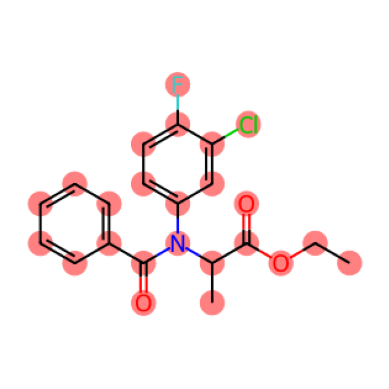

In [134]:
# Convert SMILES to RDKit molecule
mol = Chem.MolFromSmiles(smile1)

# Get atom indices from tokenized SMILES
# Assuming the tokenized form corresponds correctly to atoms in the molecule
# You might need to adjust this mapping based on your tokenizer's output
atom_indices = [i for i in range(mol.GetNumAtoms())]

# Create a color map based on integrated gradient scores
# Normalize the scores for better visualization
normed_scores = (integrated_grads_gt[0] - np.min(integrated_grads_gt[0])) / (np.max(integrated_grads_gt[0]) - np.min(integrated_grads_gt[0]))
colors = plt.cm.coolwarm(normed_scores)

# Create a drawing of the molecule with colored atoms
img = Draw.MolToImage(mol,
                       size=(300,300),
                       kekulize=True,
                       highlightAtoms=atom_indices,
                       highlightAtomColors={i: colors[i] for i in atom_indices})

# Display the image
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()

In [151]:
#  Create a molecule object from the SMILES string
mol = Chem.MolFromSmiles(smile1)

# Generate 2D coordinates for the molecule
Chem.rdDepictor.SetPreferCoordGen(True)
Draw.rdMolDraw2D.PrepareMolForDrawing(mol)

# Normalize scores for mapping to [0, 1]
min_score = np.min(integrated_grads_gt[0])
max_score = np.max(integrated_grads_gt[0])

# Scale scores to [0, 1]
normed_scores = integrated_grads_gt[0] #- min_score) / (max_score - min_score)

# Adjust for diverging colormap by centering around zero
normalized_color_values = (integrated_grads_gt - min_score) / (max_score - min_score) * 2 - 1

# Get color mapping using coolwarm colormap
colors_coolwarm = plt.cm.coolwarm(normalized_color_values, vmax=1)
colors_coolwarm = colors_coolwarm[0]
# Draw the molecule with highlighted atoms based on attention scores
atom_colors = {i: colors_coolwarm[i] for i in range(integrated_grads_gt.shape[1])}
img = Draw.MolToImage(mol, size=(300, 300), kekulize=True, wedgeBonds=True,
                      highlightAtoms=[atom.GetIdx() for atom in mol.GetAtoms()],
                      highlightAtomColors=atom_colors)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title('Molecule Visualization with Diverging Color Map')
plt.show()

TypeError: __call__() got an unexpected keyword argument 'vmax'

In [149]:
normalized_color_values

array([[-0.27610833, -0.55669464, -1.        ,  0.01747628, -0.08753959,
        -0.32405182,  0.25008061, -0.3601728 ,  0.51708221, -0.20148194,
        -0.0652077 , -0.6082685 ,  0.87624467, -0.27294928, -0.58243701,
        -0.45706094, -0.4700253 ,  0.53605316, -0.23533842,  0.79281182,
        -0.04164706,  0.00136442,  0.067603  ,  0.14392728, -0.32490699,
        -0.12382133, -0.10170758,  0.53995164, -0.5590253 ,  0.20147086,
        -0.4701392 ,  0.25924261,  0.59430427,  1.        , -0.59709869,
        -0.31814918, -0.44648739,  0.56881829, -0.31731929, -0.1121473 ,
         0.19555197,  0.08418239, -0.09014917, -0.2586245 ]])

In [142]:
atom_colors

{0: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 1: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 2: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 3: array([0.24809122, 0.32601302, 0.77766865, 1.        ]),
 4: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 5: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 6: array([0.55431187, 0.69009701, 0.99551555, 1.        ]),
 7: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 8: array([0.88368714, 0.85610772, 0.84025767, 1.        ]),
 9: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 10: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 11: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 12: array([0.86539133, 0.37112767, 0.29576896, 1.        ]),
 13: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 14: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 15: array([0.2298057 , 0.29871797, 0.75368315, 1.        ]),
 16: array([0.2298

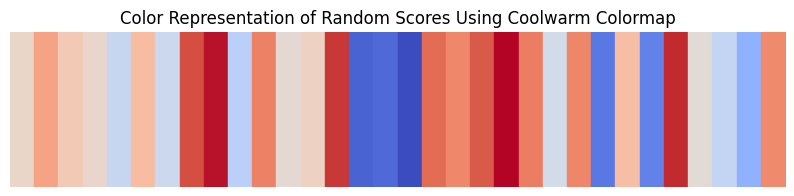

In [144]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a random vector of numbers (32 values)
np.random.seed(0)  # For reproducibility
random_scores = np.random.uniform(-1, 1, 32)  # Random values between -1 and 1

# Normalize scores for mapping to [0, 1]
min_score = np.min(random_scores)
max_score = np.max(random_scores)

# Scale scores to [0, 1]
normed_scores = (random_scores - min_score) / (max_score - min_score)

# Get color mapping using coolwarm colormap
colors_coolwarm = plt.cm.coolwarm(normed_scores)

# Plot the colors to visualize the colormap
plt.figure(figsize=(10, 2))
for i in range(len(colors_coolwarm)):
    plt.fill_between([i, i + 1], 0, 1, color=colors_coolwarm[i])
plt.xlim(0, len(colors_coolwarm))
plt.ylim(0, 1)
plt.title('Color Representation of Random Scores Using Coolwarm Colormap')
plt.axis('off')  # Turn off axis
plt.show()

# # Print the random scores and their corresponding colors
# for score, color in zip(random_scores, colors_coolwarm):
#     print(f'Score: {score:.4f}, Color: {color}')


In [145]:
colors_coolwarm

array([[0.91607053, 0.83397731, 0.78869287, 1.        ],
       [0.96491139, 0.64015908, 0.5198056 , 1.        ],
       [0.95095561, 0.78687503, 0.70476068, 1.        ],
       [0.91276506, 0.83668189, 0.79451211, 1.        ],
       [0.77737753, 0.84092121, 0.9461493 , 1.        ],
       [0.96696244, 0.73567   , 0.63087654, 1.        ],
       [0.79606387, 0.84869321, 0.93347147, 1.        ],
       [0.83018652, 0.30473276, 0.25489143, 1.        ],
       [0.72331524, 0.06889824, 0.16298851, 1.        ],
       [0.72896958, 0.81746414, 0.97318767, 1.        ],
       [0.92688298, 0.50542155, 0.39486588, 1.        ],
       [0.89588177, 0.84990606, 0.82349908, 1.        ],
       [0.9306686 , 0.818877  , 0.75914639, 1.        ],
       [0.7851533 , 0.22085109, 0.21167288, 1.        ],
       [0.2899956 , 0.38683568, 0.82892636, 1.        ],
       [0.30906032, 0.41349827, 0.85012763, 1.        ],
       [0.2298057 , 0.29871797, 0.75368315, 1.        ],
       [0.89213754, 0.42538874,

In [131]:
colors

array([[0.70358689, 0.80258564, 0.98284713, 1.        ],
       [0.51082432, 0.64939661, 0.98507878, 1.        ],
       [0.2298057 , 0.29871797, 0.75368315, 1.        ],
       [0.87555739, 0.86024216, 0.85143007, 1.        ],
       [0.81805649, 0.85558968, 0.91463762, 1.        ],
       [0.67253795, 0.78286145, 0.9919819 , 1.        ],
       [0.95951766, 0.76697285, 0.67414472, 1.        ],
       [0.64611281, 0.7644365 , 0.99686846, 1.        ],
       [0.9530536 , 0.58521087, 0.46537263, 1.        ],
       [0.75361062, 0.83023285, 0.96087116, 1.        ],
       [0.83114823, 0.85951319, 0.90311016, 1.        ],
       [0.47846225, 0.61656364, 0.9727209 , 1.        ],
       [0.79056153, 0.231397  , 0.21624204, 1.        ],
       [0.70871969, 0.80572139, 0.98111681, 1.        ],
       [0.49463849, 0.63302226, 0.97898282, 1.        ],
       [0.58148615, 0.7134506 , 0.99831435, 1.        ],
       [0.57061644, 0.70410916, 0.99719483, 1.        ],
       [0.94945399, 0.57238791,

In [105]:
normed_scores

array([1.        , 0.71766588, 0.57549373, 0.61843915, 0.85945949,
       0.63040737, 0.32225367, 0.64057702, 0.56926343, 0.62980554,
       0.55621547, 0.68490899, 0.27084942, 0.43664382, 0.24488   ,
       0.51043328, 0.71239299, 0.48535695, 0.83297086, 0.62985913,
       0.67783438, 0.81865137, 0.79340106, 0.5759598 , 0.66480786,
       0.46891658, 0.64883725, 0.49561745, 0.39170636, 0.        ,
       0.41186248, 0.50366196])

In [57]:
from rdkit.Chem import AllChem  # Ensure this line is included

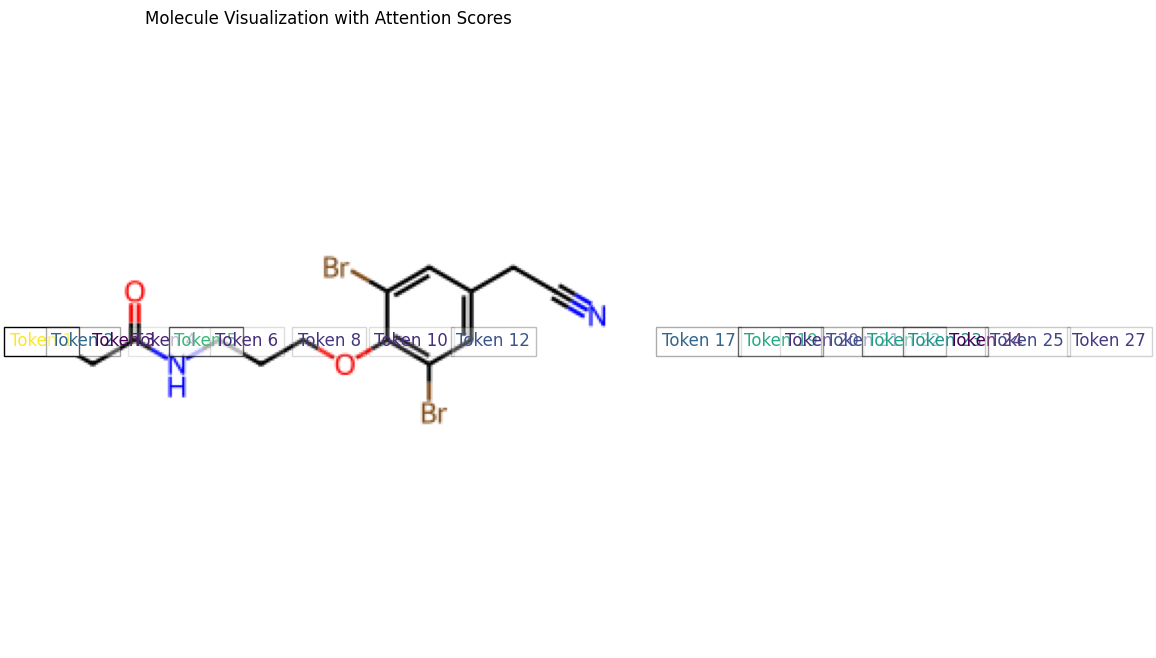

In [65]:
# Generate the molecule from SMILES
mol = Chem.MolFromSmiles(smile1)

# Compute the coordinates for the molecule
AllChem.Compute2DCoords(mol)

# Draw the molecule and get the image
img = Draw.MolToImage(mol)

# Convert the image to a numpy array for manipulation
img_array = np.array(img)

# Create a figure to display the molecule and attention scores
plt.figure(figsize=(8, 8))
plt.imshow(img_array)

# Normalize attention scores for visualization (scale to [0-1])
normalized_scores = integrated_grads_gt / np.max(integrated_grads_gt)

# Highlight regions based on attention scores
for i in range(len(normalized_scores[0])):
    if normalized_scores[0][i] > 0:
        # Get the coordinates of the token (this is a simplistic approach)
        # In practice you would map tokens to specific atom indices or coordinates
        # Here we assume a fixed position for demonstration purposes.
        plt.text(10 + i * 20, img_array.shape[0] // 2,
                 f'Token {i+1}', fontsize=12,
                 color=plt.cm.viridis(normalized_scores[0][i]), 
                 ha='center', va='center', 
                 bbox=dict(facecolor='white', alpha=normalized_scores[0][i]))

plt.axis('off') # Hide axes
plt.title('Molecule Visualization with Attention Scores')
plt.show()

In [60]:
normalized_scores.shape

(1, 32)

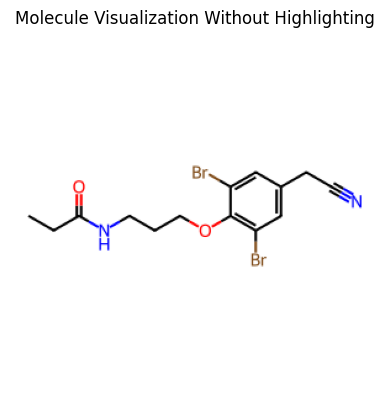

In [83]:
# Create a molecule object from the SMILES string
mol = Chem.MolFromSmiles(smile1)

# Generate 2D coordinates for the molecule
Chem.rdDepictor.SetPreferCoordGen(True)
Draw.rdMolDraw2D.PrepareMolForDrawing(mol)

# Draw the molecule without highlighting or colors
img = Draw.MolToImage(mol, size=(300, 300), kekulize=True, wedgeBonds=True)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title('Molecule Visualization Without Highlighting')
plt.show()

> c:\users\86136\appdata\local\temp\ipykernel_86784\2524658980.py(27)visualize_molecule()



array([ 1.37860253e-02,  4.64178436e-03,  3.71107380e-05,  1.42802764e-03,
        9.23419744e-03,  1.81565457e-03, -8.16483144e-03,  2.14502914e-03,
       -1.64676268e-04,  1.79616234e-03, -5.87273738e-04,  3.58085381e-03,
       -9.82971303e-03, -4.45996178e-03, -1.06708109e-02, -2.07006792e-03,
        4.47100587e-03, -2.88224034e-03,  8.37628357e-03,  1.79789809e-03,
        3.35172121e-03,  7.91250356e-03,  7.09469616e-03,  5.22058908e-05,
        2.92981789e-03, -3.41471145e-03,  2.41256179e-03, -2.54992326e-03,
       -5.91539685e-03, -1.86019875e-02, -5.26258023e-03, -2.28937739e-03])


In [90]:
from rdkit.Chem import rdmolops


IndexError: index 32 is out of bounds for axis 0 with size 32

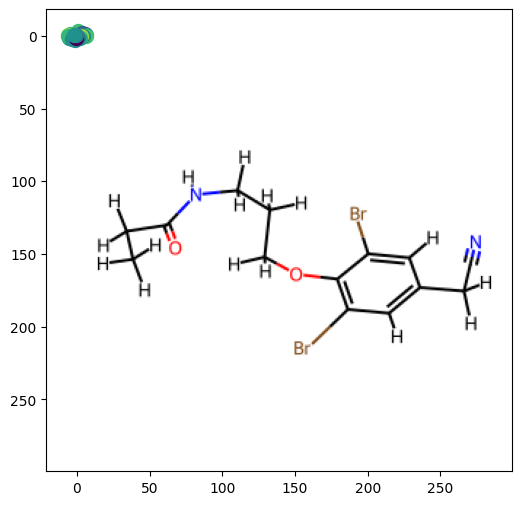

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

# Assuming you have the following variables defined:
# smile1: The SMILES string of the molecule
# smile_dict['input_ids']: A (1, 32) tensor with tokenized SMILES
# integrated_grads_gt: Attention scores per token

# Convert the SMILES string into an RDKit molecule object
mol = Chem.MolFromSmiles(smile1)

# Add hydrogens to the molecule
mol_with_h = Chem.AddHs(mol)

# Generate 2D coordinates for the molecule using ETKDG method
params = AllChem.ETKDG()
AllChem.EmbedMolecule(mol_with_h, params)

# Optimize the geometry
AllChem.UFFOptimizeMolecule(mol_with_h)

# Get the conformer to retrieve atom positions
conformer = mol_with_h.GetConformer()
positions = conformer.GetPositions()  # Get all atom positions

# Create a mapping from tokens to the atoms in the molecule
tokens = [Chem.MolToSmiles(mol, True)[i] for i in range(len(smile_dict['input_ids'][0]))]
attention_scores = integrated_grads_gt[0]

# Normalize attention scores for better visualization
norm_attention_scores = (attention_scores - np.min(attention_scores)) / (np.max(attention_scores) - np.min(attention_scores))

# Create a color map based on attention scores
colors = plt.cm.viridis(norm_attention_scores)

# Create a 2D visualization of the molecule with highlighted regions
fig, ax = plt.subplots(figsize=(8, 6))
img = Draw.MolToImage(mol_with_h, size=(300, 300), kekulize=True)
ax.imshow(img)

# Overlay attention scores on the image
for i, atom in enumerate(mol_with_h.GetAtoms()):
    pos = positions[i]  # Get position of each atom from positions array
    ax.scatter(pos[0], pos[1], color=colors[i], s=100)  # Adjust size as needed

# Optionally add a color bar for reference
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=np.min(attention_scores), vmax=np.max(attention_scores)))
sm.set_array([])
plt.colorbar(sm, ax=ax)

plt.title('Molecule Visualization with Attention Scores')
plt.axis('off')  # Hide axes
plt.show()


# Plotting training metrics

In [17]:
def plot_metrics(metrics_dict):
    epochs = range(1, len(metrics_dict['Train Loss']) + 1)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # Plot Train and Validation Loss
    axs[0].plot(epochs, metrics_dict['Train Loss'], label='Train Loss', color='blue', marker='o')
    axs[0].plot(epochs, metrics_dict['Valid Loss'], label='Valid Loss', color='orange', marker='o')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot Train and Validation AUROC
    axs[1].plot(epochs, metrics_dict['Train AUROC'], label='Train AUROC', color='green', marker='o')
    axs[1].plot(epochs, metrics_dict['Valid AUROC'], label='Valid AUROC', color='red', marker='o')
    axs[1].set_title('AUROC Over Epochs')
    axs[1].set_ylabel('AUROC Score')
    axs[1].legend()
    axs[1].grid()

    
    # Plot Validation F1 Score
    axs[2].plot(epochs, metrics_dict['Valid F1'], label='Valid F1 Score', color='purple', marker='o')
    axs[2].set_title('Validation F1 Score Over Epochs')
    axs[2].set_ylabel('F1 Score')
    
    
    # Create a separate plot for Learning Rate
    fig_lr, ax_lr = plt.subplots(figsize=(10, 5))
    ax_lr.plot(epochs, metrics_dict['lr'], label='Learning Rate', color='cyan', linestyle='--', marker='o')
    ax_lr.set_title('Learning Rate Over Epochs')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.grid()
    fontsize = 12
    # Label points for each plot
    for i in range(0, len(metrics_dict['lr']), 10):
        axs[0].text(epochs[i], metrics_dict['Train Loss'][i], f"{metrics_dict['Train Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[0].text(epochs[i], metrics_dict['Valid Loss'][i], f"{metrics_dict['Valid Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        
        axs[1].text(epochs[i], metrics_dict['Train AUROC'][i], f"{metrics_dict['Train AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[1].text(epochs[i], metrics_dict['Valid AUROC'][i], f"{metrics_dict['Valid AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        axs[2].text(epochs[i], metrics_dict['Valid F1'][i], f"{metrics_dict['Valid F1'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        ax_lr.text(epochs[i], metrics_dict['lr'][i], f"{metrics_dict['lr'][i]:.4f}", 
                   fontsize=fontsize, ha='right', color='k')

    # Set common x-label
    axs[-1].set_xlabel('Epochs')
    
    plt.tight_layout()
    
    # Show plots
    plt.show()

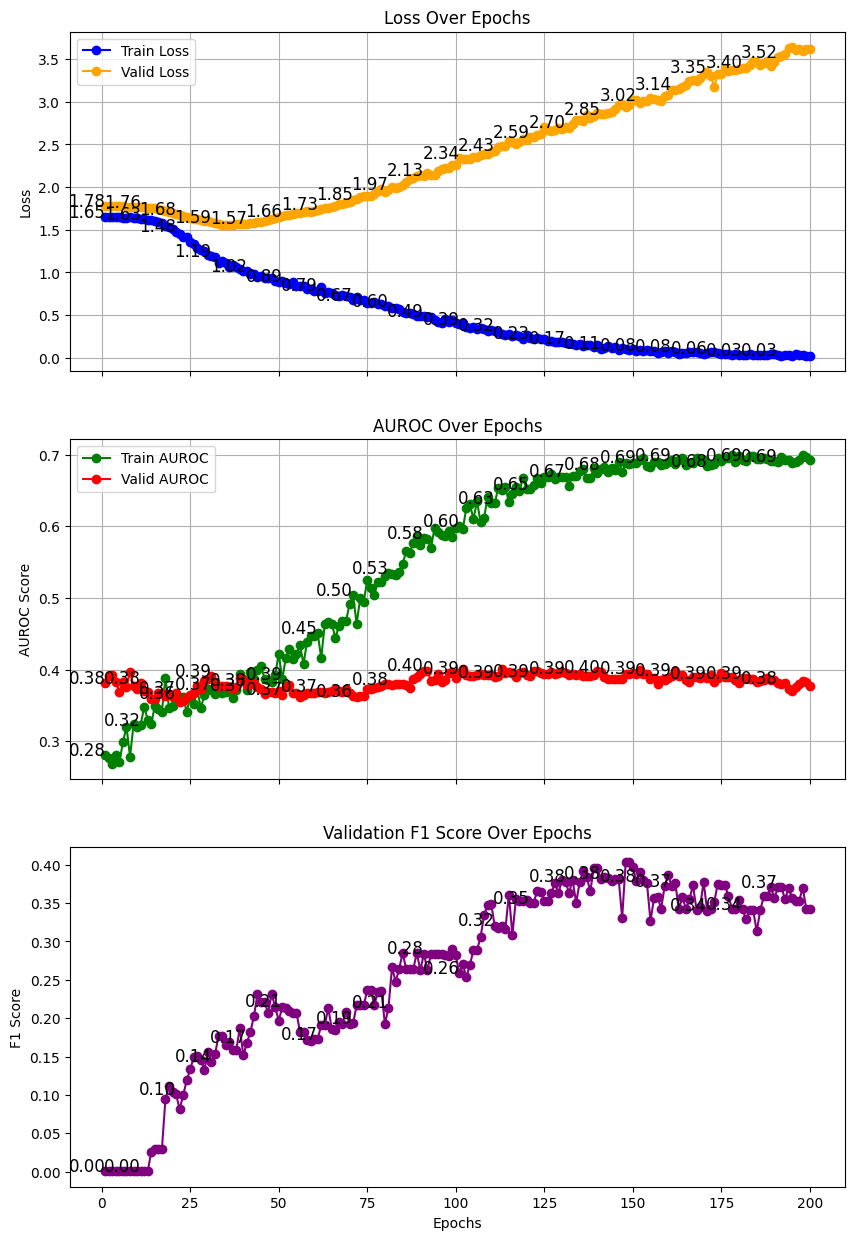

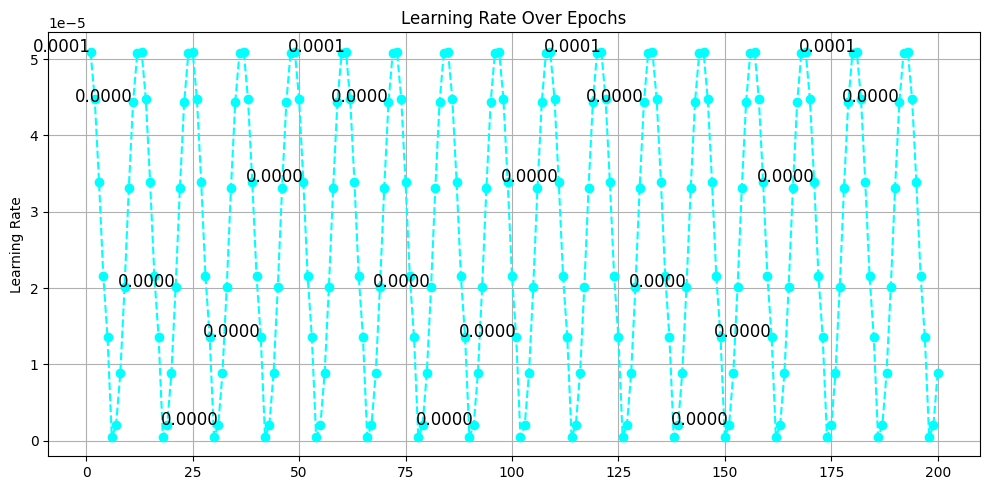

In [18]:
plot_metrics(history)

In [20]:
val_epoch_loss, val_epoch_auroc, val_epoch_f1 = valid_one_epoch(model=model, dataloader=validloader, criterion=criterion, 
                                         epoch=1)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s, Epoch=1, Valid_Auroc=0.422, Valid_F1=0.428, Valid_Loss=1.86]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00, 73.29it/s, Epoch=1, Valid_Auroc=0.394, Valid_F1=0.403, Valid_Loss=2.96]
